# Disparities in State/County Voter Turnout: Understanding Social Capital

__ Prathm Juneja and Stephen Meisenbacher __

__ University of Notre Dame __

__ CSE44648: Data Science __

__ 7/28/2017 __

## Introduction
Political scientists for decades have often debated whether the low voter turnout in the USA is a question of cultural norms or voting policies. Many believe that even if we were to make voting in the United States substantially easier, we wouldn’t see large increases in turnout because the culture of voting doesn’t exist. What is often used is state by state data, where some political scientists will argue that because some states make it easier to vote, they have higher voter turnout rates (e.g. Minnesota), and the ones that don’t, see lower turnout rates (e.g. Georgia). Opponents of this theory will say that Minnesotans were always voting at a high level, and that culture of wanting to vote is what drove the policy changes, not the other way around. The way this has been traditionally studied is by grouping states into “cultural/geographic” segments, and then comparing turnout among them. 

The premise of this project is to use data available from previous elections to test whether the differences among different states is cultural or policy oriented. By using the "social capital" dataset - a quantified civic participation metric - we have trained algorithms to predict turnout rates. These algorithms were then used to see if turnout can accurately be predicted using the social capital cultural features, allowing us to see whether or not culture is the most important factor in turnout.

## Related Work

The topic of voter turnout is one of the most frequently studied in Political Science. However, the topic that this paper seeks to study, understanding turnout through social capital and cultural variables, was inspired by the work done by Robert Putnam and Michael Hamner. 

Hamner's work, Discount Voter, is centered on voter registration, not turnout, but also explored the affects of registration on turnout. He concluded that while policy reforms can make minor differences in turnout, they aren't as large as political talking points would have you believe. He argues that since the states that already have voting-centric cultures are the ones most likely to advance big policy changes to make registering easy, state differences in turnout can be accredited to culture, not policy differences.

The concept of social capital was a central theme of Putnam's work Bowling Alone. In short, his work sought to show that there are ways of capturing "civic engagement" that difer from our traditional understanding them. Volunteering in communities, non-profit organizations, and even sports/activities clubs are all forms of civic engagement, much like voting in elections and campaigning for candidates. The data that is used for this paper, explained below, is an extension of the social capital index that Putnam argues for. 

In our exploration of computer science approaches to this topic, we were unable to find anyone who used big data or data science techniques to try and explore it. As a result, there is no large data science background for this work, just the statistical and qualitative analysis of political scientists. 

## Data and Preprocessing

First, we import the libraries we will be using throughout the course of the project:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

C:\Users\prath\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Sets
Below, we import the two datasets that are used for the project. They are the 2009 and 2014 Penn State County-level Measure of Social Capital data sets. The datasets use a "fips" number that represents every county in the country, and have various features for each of the counties. Those features include things like the amount of civic institutions, the amount of bowling alleys, and the amount of sports clubs. All of those cultural factors are divided by population and then are aggregated in the assn category. The rspn category is the response rate to the census, and the nccs is the amount of non-profits in the area. Finally, the pvote column represents the presidential vote in the last presidential election. The original data source, as well as the variable explanations, can be found here: http://aese.psu.edu/nercrd/community/social-capital-resources/social-capital-variables-for-2014

In [17]:
# Read in 2009 and 2014 datasets
filename2009 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202009%20with%20turnout.csv'
filename2014 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202014%20with%20turnout.csv'
data2009 = pd.read_csv(filename2009)
data2014 = pd.read_csv(filename2014)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   fips  statcode     areaname  relig  civic  bus  pol  prof  labor  bowl  \
0  1001         1  Autauga, AL   50.0    7.0  3.0  NaN   1.0    5.0   1.0   
1  1003         1  Baldwin, AL  161.0   21.0  7.0  NaN   1.0    2.0   2.0   
2  1005         1  Barbour, AL   17.0    1.0  1.0  NaN   NaN    1.0   1.0   
3  1007         1     Bibb, AL   27.0    NaN  1.0  NaN   NaN    NaN   NaN   
4  1009         1   Blount, AL   42.0    1.0  1.0  NaN   NaN    1.0   NaN   

   fitns  golf  sport       pop  respn   nccs      assn     pvote  
0    4.0   2.0    NaN   50756.0   0.78  182.0  1.438254  0.635648  
1   18.0   8.0    NaN  179878.0   0.73  737.0  1.223051  0.608996  
2    1.0   2.0    NaN   29737.0   0.63  107.0  0.807075  0.512425  
3    1.0   1.0    NaN   21587.0   0.58   59.0  1.389725  0.522517  
4    3.0   4.0    NaN   58345.0   0.80  121.0  0.891250  0.555640  
2014:
   FIPS  relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport  \
0  1001   53.0    7.0  3.0  NaN   1.0    4.

### Data Preprocessing
Before we start to train any models, a bit of preprocessing is required. We had to delete columns that would skew the data, remove counties that were not in both datasets, and also separate the data. This is all performed below:

In [3]:
# delete missing counties in the 2009 dataset
fips2009 = data2009['fips'].tolist()
fips2014 = data2014['FIPS'].tolist()

# delete any FIPS that are not in both datasets
index = 0
toDelete = []
for fip in fips2014:
    if fip not in fips2009:
        toDelete.append(index)
    index = index + 1
data2014 = data2014.drop(toDelete, axis=0)

index = 0
toDelete = []
for fip in fips2009:
    if fip not in fips2014:
        toDelete.append(index)
    index = index + 1
data2009 = data2009.drop(toDelete, axis=0)

# get rid of unnecessary columns
data2009 = data2009.drop(['fips', 'areaname', 'statcode'], axis=1)
data2014 = data2014.drop(['FIPS'], axis=1)

# Impute missing values with 0
data2009 = data2009.fillna(value=0)
data2014 = data2014.fillna(value=0)

# Separate into x and y
X2009 = data2009.iloc[:, :-1]  # features
y2009 = data2009.iloc[:, -1]  # class (turnout)

X2014 = data2014.iloc[:, :-1]  # features
y2014 = data2014.iloc[:, -1]  # class (turnout)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport       pop  \
0   50.0    7.0  3.0  0.0   1.0    5.0   1.0    4.0   2.0    0.0   50756.0   
1  161.0   21.0  7.0  0.0   1.0    2.0   2.0   18.0   8.0    0.0  179878.0   
2   17.0    1.0  1.0  0.0   0.0    1.0   1.0    1.0   2.0    0.0   29737.0   
3   27.0    0.0  1.0  0.0   0.0    0.0   0.0    1.0   1.0    0.0   21587.0   
4   42.0    1.0  1.0  0.0   0.0    1.0   0.0    3.0   4.0    0.0   58345.0   

   respn   nccs      assn     pvote  
0   0.78  182.0  1.438254  0.635648  
1   0.73  737.0  1.223051  0.608996  
2   0.63  107.0  0.807075  0.512425  
3   0.58   59.0  1.389725  0.522517  
4   0.80  121.0  0.891250  0.555640  
2014:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport     pop  \
0   53.0    7.0  3.0  0.0   1.0    4.0   1.0    5.0   2.0    0.0   55290   
1  169.0   16.0  9.0  0.0   3.0    1.0   1.0   25.0   7.0    0.0  199713   
2   19.0    1.0  1.0  0.0   0.0    0.0   0.0    0.0   1.0    0.

### Data Visualization

The first graph, a boxplot, interestingly shows the variance in the several features of the 2009 dataset.

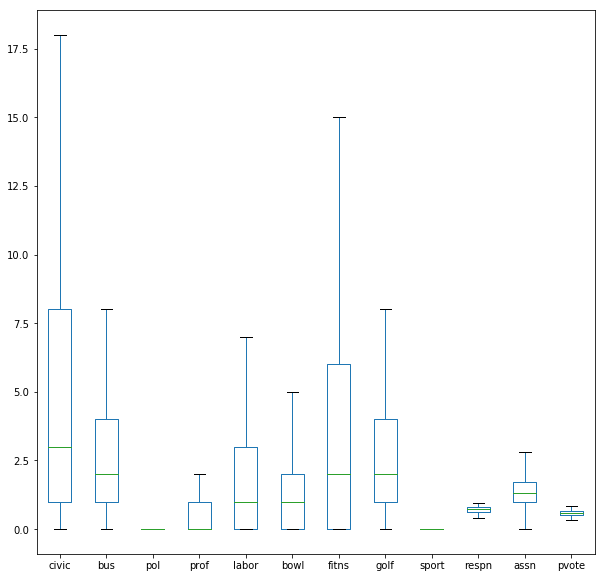

In [4]:
# boxplot most of the 2009 dataset
box2009 = data2009.drop(['relig', 'pop', 'nccs'], axis=1).plot.box(grid=False, figsize=(10,10), showfliers=False)

The plots below show the variance in a bit of a different manner, but more importantly, it shows that for the most part, the feature values remain within a set range, with a few outliers.

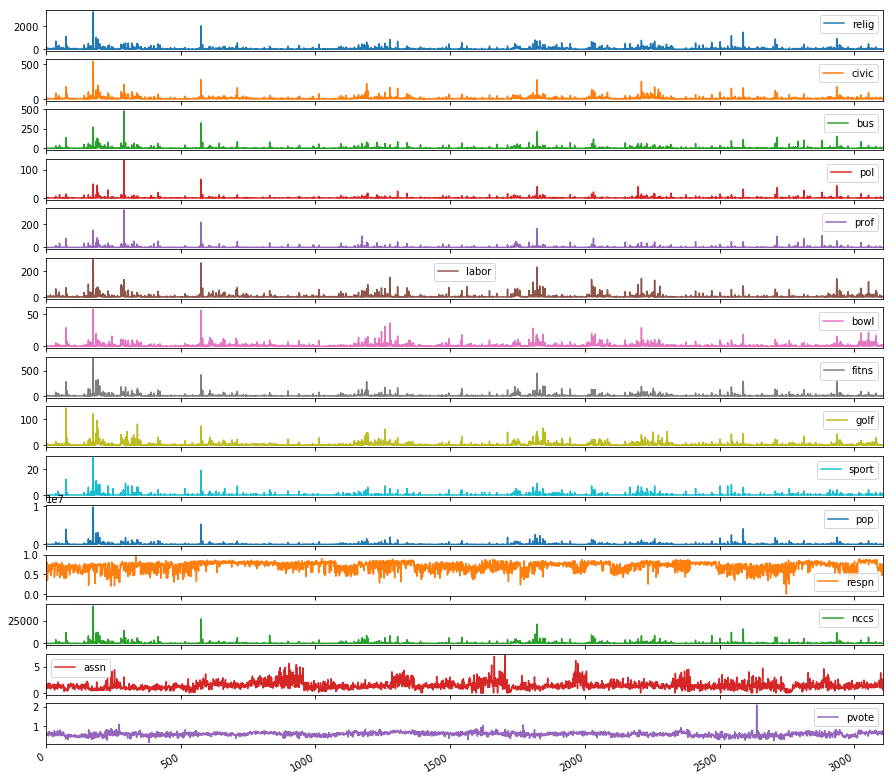

In [5]:
plot2009 = data2009.plot(figsize=(15, 15), subplots=True)

The scatter matrix below displays the relatedness of our four most important features: RESPN, NCCS, ASSN, and PVOTE. As can be seen, the different features on display share varying degrees of relatedness, as some features are very tightly plotted together, while others show a wider spread

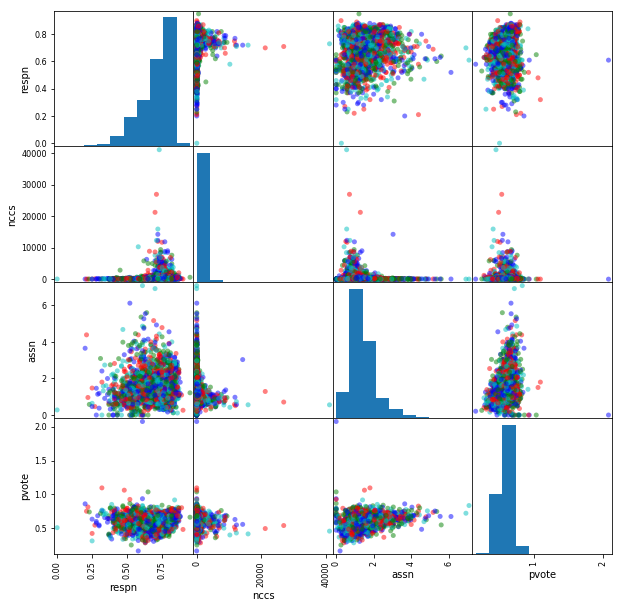

In [6]:
my_colors = ['g', 'b', 'r', 'c']
scatter = pd.plotting.scatter_matrix(data2009.iloc[:, 11:15], diagonal='hist', figsize=(10,10), color=my_colors, s=100)

### Principal Component Analysis
Here we will perform Principal Component Analysis (PCA) on the 2009 dataset. The resulting plot displays our first two principal components. Upon observing the graph, one can see that the first principal component is possibly affected by an outlying value.

[  9.99999978e-01   1.72122874e-08   2.46591185e-09]


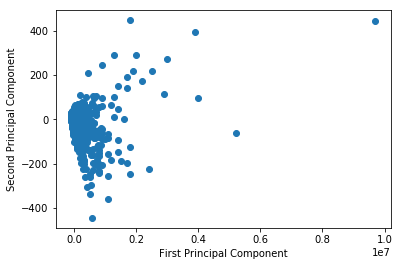

In [7]:
from sklearn import decomposition
# Projection onto the first 2 principal components.

Xpca = X2009.iloc[:, :-3]

# Global centering.
data_centered = Xpca - Xpca.mean()
    
pca = decomposition.PCA(n_components=3)
data_pca = pca.fit_transform(data_centered.dropna())

print(pca.explained_variance_ratio_)

# Plot the data according to the first two principal components.
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

## Methods and Experiments

### Introduction

The main premise of our methods/expirements is to study whether the cultural variables can serve as accurate predictors of turnout. If this is true, it would be reasonable to say that the effects of policy, as Hamner argued, are minimal, because culture itself can predict turnout, regardless of the policies put in place. To do this, we decided to employ two main techniques, linear regression and k-means clustering.

### Linear Regression
Below, we perform linear regression to predict what the 2014 voter turnout should be based upon the 2009 data. We train a regression model on the 2009 data, and then test to see if that trained model, when given the cultural variables of the 2014 data, can accurately predict the turnout for 2014. We then calculate the mean squared error of the regression. The model is trained on the cultural components of the assn variable, since that is what we are hoping to test. Finally, we visualize the regression.

In [32]:
regr = LinearRegression()

# train data on 2009 data set
regr.fit(X2009.iloc[:, :-4], y2009)

# predict on 2014 data
y_pred = regr.predict(X2014.iloc[:, :-4])
#print('Regression Prediction:')
print (y_pred)
print('\n' + 'Coefficients for Regression:')
print(regr.coef_)

[ 0.58261105  0.55585861  0.58411642 ...,  0.59436216  0.59463991
  0.58896524]

Coefficients for Regression:
[ -3.07895147e-04  -1.69514927e-05  -1.16449996e-03   1.55854870e-03
   1.56966889e-03  -2.09436123e-04   7.99164196e-03   2.03150993e-04
   1.65445904e-03   2.91157438e-03]


In [27]:
# display the mean squred error
print('Mean Squared Error: %.4f' % np.average((y2014 - y_pred) ** 2))

Mean Squared Error: 2541.4924


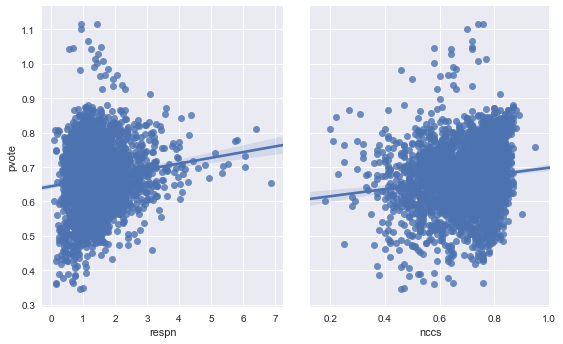

In [33]:
import seaborn as sns

# visualize the regression
sns.pairplot(data2014, x_vars=['respn','nccs'], y_vars=["pvote"],
             size=5, aspect=.8, kind="reg");

In [11]:
# convert result to list
y2014 = y2014.tolist()

While our overall mean squared error was very low, we want to see which counties did a poor job of being predicted upon. As a result, we have selected a threshold of 0.3 error, and we're looking to find all of the counties that were off by that much. We can then try and explain these differences in poor prediction based on cultural/policy changes in those specific counties.

In [34]:
largestDiffs = [] # list of the counties that exceed our decided threshold
threshold = 0.3
count = 0
# loop through real and predicted values
# pick out indices that exceed threshold of .30 between real and predicted values
for i in range(len(y2014)):
    real = y2014[i]
    pred = y_pred[i]
    if real + threshold < pred or real - threshold > pred:
        largestDiffs.append(count)
    count = count + 1
    
print (len(largestDiffs))
print(largestDiffs)

# print data for each of the found counties that exceeded our threshold
#for i in largestDiffs:
 #   print(data2014.iloc[i, :])

26
[175, 1364, 2206, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105]


### K-means Clustering
In addition to our results from Linear Regression, we are curious to see what a K-means Clustering model would do on the same 2009 data. To do this, we while choose many k's, and then observe which k best clusters our data. The idea here is to use the 3 cultural aggregates: respn, nccs, and assn, to put each of the counties into a specific cluster.

In [42]:
X2014.iloc[:, 2].head()

0    3.0
1    9.0
2    1.0
3    1.0
4    1.0
Name: bus, dtype: float64

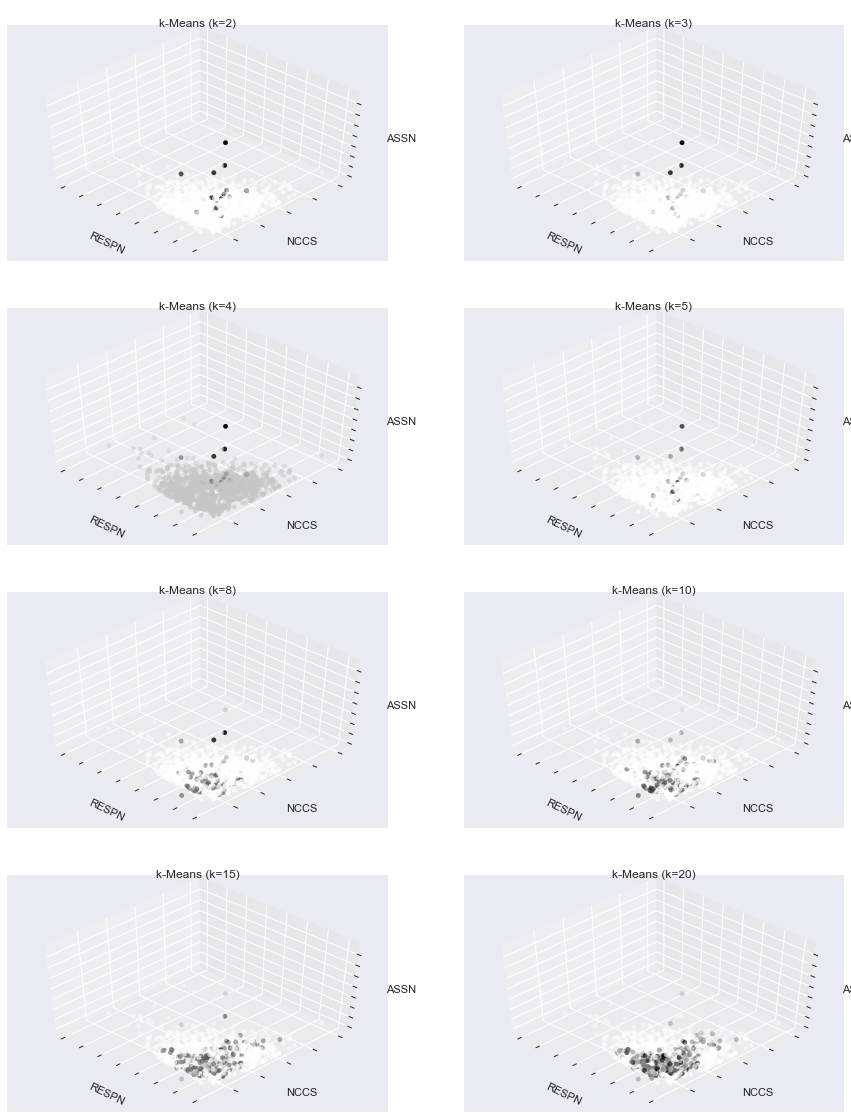

In [55]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# cluster based on last 4 columns
X = X2014.iloc[:, -3:]

# get rid of any possible outlying values in ASSN
#index = 0
#for assn in X.iloc[:, 2].tolist():
 #   if assn > 3:
  #      X.drop(index, axis=0)
   #     break
   # index = index + 1

# Define a set of k-means estimators.
estimators = {'k-Means (k=2)': KMeans(n_clusters=2),
              'k-Means (k=3)': KMeans(n_clusters=3),
              'k-Means (k=4)': KMeans(n_clusters=4),
              'k-Means (k=5)': KMeans(n_clusters=5),
              'k-Means (k=8)': KMeans(n_clusters=8),
              'k-Means (k=10)': KMeans(n_clusters=10),
              'k-Means (k=15)': KMeans(n_clusters=15),
              'k-Means (k=20)': KMeans(n_clusters=20)}

# Define a matplotlib figure.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

labelEval = [] # label to be used in evaluation (k=10)
fignum = 1
for name, est in estimators.items():
    ax = plt.subplot(4, 2, fignum, projection='3d', elev=48, azim=134)

    # Fit the estimator.
    est.fit(X)
    labels = est.labels_
    if name == 'k-Means (k=10)': # to be used in evaluation
        labelEval = labels
    
    # Define a scatterplot.
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=labels.astype(np.float))

    # Customize the plot.
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('RESPN')
    ax.set_ylabel('NCCS')
    ax.set_zlabel('ASSN')
    plt.title("\n" + name + "\n")
    fignum = fignum + 1

Above, we used cultural factors, that did not include voter turnout, to predict the groups into clusters, and then we displayed those predicted clusters. Now, we will take the turnout data for every county, and bin the turnouts into 10 bins, and use those bins as classes. Essentially, if those class based clusters below look similar to the clusters that were created based off of the cultural factors, then we know that you can classify counties by their culture, and that those classifications are nearly the same as if you classify them based on their turnout level.

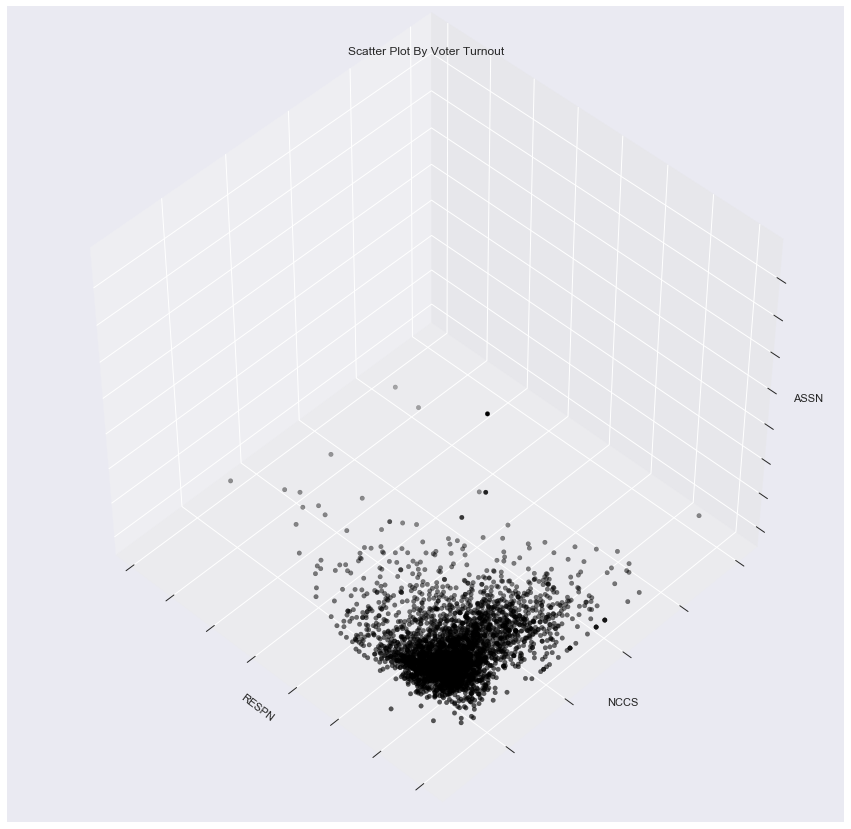

In [57]:
# isolate PVOTE column
Xvt = y2014

# bin the voter turnout
numbins = 10
bins = pd.qcut(Xvt, numbins, retbins=True)[1]

# define color scale based upon bins
color = [str(item/255) for item in bins]
cm = plt.cm.get_cmap('RdYlBu')

# Define a matplotlib figure.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

fignum = 1
ax = plt.subplot(1, 1, fignum, projection='3d', elev=48, azim=134)

# Define a scatterplot.
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=color, cmap=cm)

# Customize the plot.
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('RESPN')
ax.set_ylabel('NCCS')
ax.set_zlabel('ASSN')
plt.title("\n" + 'Scatter Plot By Voter Turnout' + "\n")

As you can see, if you compare the clustering to the actual binned classification, the results are somewhat similar. This, however, is not nearly as accurate as the regression model.

Below, we used some basic clustering scores to test the accuracy. While we have a high completeness score, the homegeniout and v_measure_score are actually quite small, and could be because the amount of available clusters and bins was too few.


In [59]:
# test our clusters using several scores
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

print(completeness_score(labels_true=y2014, labels_pred=labelEval))
print(homogeneity_score(labels_true=y2014, labels_pred=labelEval))
print(v_measure_score(labels_true=y2014, labels_pred=labelEval))

0.999494854116
0.109831490712
0.197914725992


As you can see above, the turnout based classification yields very similar results to the cultural based clustering, which shows that there is a clear correlation between them. 

### Testing for signficance
Finally, we test the the statistical signifcance of each of our three core cultural components: RESPN, NCCS, and ASSN, with regard to voter turnout.

In [ ]:
from scipy.stats import pearsonr
print('Evaluation for Statistical Significance:')
print('RESPN-PVOTE:')
print(pearsonr(data2009['respn'],data2009['pvote']))
print('NCCS-PVOTE:')
print(pearsonr(data2009['nccs'],data2009['pvote'])) 
print('ASSN-PVOTE:')
print(pearsonr(data2009['assn'],data2009['pvote']))
# definitely significant, and this is aggregate of the other big variables, so this makes a ton of sense

From these significance tests, we can see that ASSN is statistically significant with a p value of 2e-49 and that RESPN is also significant, with a p value of .002. These correlations make sense when looking at the data set. RESPN is a means of measuring response rates to the census, which one would expect to be an indicator of turnout as well. ASSN is an aggregation of all of the cultural factors of the social capital index, such as number of community organizations and sports clubs. So if the social capital theory is sound, it also makes sense that this is significant. While NCCS is not a significant relationship, we include it in our tests because the social capital indexes believe in its importance, and our goal was to test those, not to develop the best means of predicting turnout.

## Summary of Evaluation and Results

As mentioned above, both the k-means clustering and linear regression models can be used as evidence that turnout is mainly based on the "social capital" cultural values. The linear regression model, when trained on the 2009 data, had a mean squared error of .0147 on the 2014 data. The k-means clustering, when using 10 clusters, did not offer as accurate of an indication, but did have a .99 completeness score.

The regression results can be used to argue that the variables that make up the social capital index, and by extension the culture, of a county can be used to predict the voter turnout of a county. These results support past political science work, and can also be used to detect anomolies. In terms of future research, there are clear outliers in the data, with many counties failing predictions by over 30%. In the future, we can use these results to study why the predictions failed for a few counties, and whether policy changes had any role to play in that. Additionally, adding different columns to the data, such as political contributions, demographics, and political polarization by county could improve predictions and also be used in other studies that try and quantify general civic engagement. 